In [1]:
import os
import numpy as np
import os.path as op
import zipfile

In [2]:
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve

dataset = "http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip"
zip_filename = dataset.rsplit('/', 1)[1]
dataset_folder = 'bbc'
if not op.exists(zip_filename):
    print("Téléchargement de %s vers %s..." % (dataset, zip_filename))
    urlretrieve(dataset, zip_filename)

if not op.exists(dataset_folder):
    with zipfile.ZipFile(zip_filename, 'r') as f:
        print("Extraction %s..." % zip_filename)
        f.extractall('.')

#### Les sujets du dataset

In [3]:
topics = sorted(folder for folder in os.listdir(dataset_folder)
                      if op.isdir(op.join(dataset_folder, folder)))
topics

['business', 'entertainment', 'politics', 'sport', 'tech']

In [4]:
from sklearn.model_selection import train_test_split

target = []
fn = []
for target_id, target_name in enumerate(topics):
    class_path = op.join(dataset_folder, target_name)
    for filename in sorted(os.listdir(class_path)):
        fn.append(op.join(class_path, filename))
        target.append(target_id)

target = np.asarray(target, dtype=np.int32)
target_train, target_test, fn_train, fn_test = train_test_split(
    target, fn, test_size=300, random_state=0)

### Affichage des 500 premiers caractères d'un des fichiers

In [5]:
n = 500
index = 69
with open(fn_train[index], "rb") as file:
    print("Catégorie du document :", topics[target_train[index]])
    print()
    print("| " + file.read().decode("latin-1")[:n] + ' |')
    print()
    print("Fin des " + str(n) + ' premiers caractères.')

Catégorie du document : tech

| What's next for next-gen consoles?

The next generation of video games consoles are in development but what will the new machines mean for games firms and consumers? We may not know when they will be released, what they will be called or even what they will be able to do but one thing is certain - they are coming. Sony, Microsoft and Nintendo are all expected to release new machines in the next 18 months. The details of PlayStation 3, Xbox 2 (codename Xenon) and Nintendo's so-called Revolution a |

Fin des 500 premiers caractères.


In [6]:
fnt = fn_train[0]
print(len(open(fnt, 'rb').read()))

4257


### Affichage de la taille du set de training

In [7]:
taille_totale = sum([len(open(fnt, 'rb').read()) for fnt in fn_train])
print("Taille total du set de training: %0.3f MB" % (taille_totale / 1e6))

#On rajoute une division par 1 Million pour le print, sinon le résultat est en octet.

Taille total du set de training: 4.332 MB


In [8]:
textes_train = [open(fnt, 'rb').read().decode('latin-1') for fnt in fn_train]
textes_test = [open(fnt, 'rb').read().decode('latin-1') for fnt in fn_test]

### Premier modèle simple (régression logistique)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline



classificateur_texte = make_pipeline(
    TfidfVectorizer (min_df=3, max_df=0.7, ngram_range=(1, 2)),
    LogisticRegression(multi_class="multinomial", solver="lbfgs"),
)

In [10]:
%time _ = classificateur_texte.fit(textes_train, target_train)
print ( "Taux de bon classement : " +  str (classificateur_texte.score(textes_test, target_test)))

Wall time: 4.08 s
Taux de bon classement : 0.97


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

MAX_WORDS = 15000

tokenizer = Tokenizer(num_words=MAX_WORDS, char_level=False)
tokenizer.fit_on_texts(textes_train)
sequences = tokenizer.texts_to_sequences(textes_train)
sequences_test = tokenizer.texts_to_sequences(textes_test)

word_index = tokenizer.word_index
print('%s tokens uniques trouvés.' % len(word_index))


30213 tokens uniques trouvés.


In [12]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 30213)

In [13]:
idx_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

### Exemple de séquences obtenues par ce procédé ;

In [14]:
" ".join([idx_to_word[i] for i in sequences[0]])

"ireland 19 13 england ireland consigned england to their third straight six nations defeat with a stirring victory at lansdowne road a second half try from captain brian o'driscoll and 14 points from ronan o'gara kept ireland on track for their first grand slam since 1948 england scored first through martin corry but had tries from mark cueto and josh lewsey disallowed andy robinson's men have now lost nine of their last 14 matches since the 2003 world cup final the defeat also heralded england's worst run in the championship since 1987 ireland last won the title then the five nations in 1985 but 20 years on they share top spot in the table on maximum points with wales and eddie o'sullivan's side the of 2003 when england were rampant 42 6 victors in claiming the grand slam at lansdowne road in front of a home crowd on a dry but day in dublin ireland tore into the white visitors from the kick off and made their intentions clear when o'gara landed a fourth minute drop goal england took 

In [15]:
seq_lens = [len(s) for s in sequences]
print("longueur moyenne: %0.1f" % np.mean(seq_lens))
print("longueur maximale: %d" % max(seq_lens))

longueur moyenne: 375.7
longueur maximale: 3237


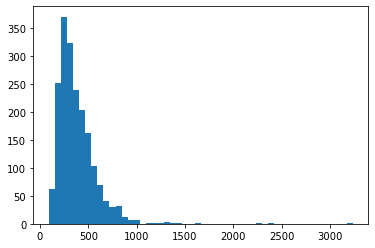

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist([l for l in seq_lens if l < 4000], bins=50);

#### La grande majorité des séquences ont moins de 1000 caractères, on peut s'en contenter.

## Préparation des données

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

longueur_max = 1000
x_train = pad_sequences(sequences, maxlen = longueur_max)
x_test = pad_sequences(sequences_test, maxlen = longueur_max)

print('Dimension des données test:', x_test.shape)
print('Dimension des données train:', x_train.shape)

Dimension des données test: (300, 1000)
Dimension des données train: (1925, 1000)


In [19]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(target_train)
y_test = to_categorical(target_test)

print('Dimension de y_train :', y_train.shape)

Dimension de y_train : (1925, 5)


### Modèle 1; words embeddings 

Epoch 1/10
55/55 [==============================] - 1s 15ms/step - loss: 1.4402 - acc: 0.4602 - val_loss: 1.1363 - val_acc: 0.7461
Epoch 2/10
55/55 [==============================] - 1s 12ms/step - loss: 0.7625 - acc: 0.8516 - val_loss: 0.4746 - val_acc: 0.9585
Epoch 3/10
55/55 [==============================] - 1s 12ms/step - loss: 0.2962 - acc: 0.9711 - val_loss: 0.2312 - val_acc: 0.9896
Epoch 4/10
55/55 [==============================] - 1s 12ms/step - loss: 0.1389 - acc: 0.9902 - val_loss: 0.1676 - val_acc: 0.9845
Epoch 5/10
55/55 [==============================] - 1s 12ms/step - loss: 0.0818 - acc: 0.9942 - val_loss: 0.1155 - val_acc: 0.9896
Epoch 6/10
55/55 [==============================] - 1s 12ms/step - loss: 0.0495 - acc: 0.9983 - val_loss: 0.0984 - val_acc: 0.9845
Epoch 7/10
55/55 [==============================] - 1s 11ms/step - loss: 0.0327 - acc: 1.0000 - val_loss: 0.0830 - val_acc: 0.9793
Epoch 8/10
55/55 [==============================] - 1s 12ms/step - loss: 0.0229 - a

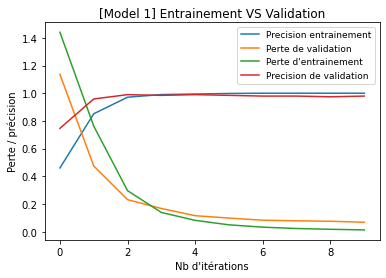

Erreur de test : 0.037

Précision moyenne sur set de validation : 0.956

Précision sur set de validation à la fin de l'entrainement : 0.979


In [20]:
from tensorflow.keras.layers import Embedding, Dense, Input, Flatten
from tensorflow.keras.layers import Conv1D, LSTM, GRU
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D 
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from matplotlib import pyplot

MAX_SEQ_LENGTH = 1000
EMB_DIM = 50
CLASSES = len(topics)

sequence_input = Input(shape=(MAX_SEQ_LENGTH,), dtype='int32')
embedding_layer = Embedding(MAX_WORDS, EMB_DIM,
                            input_length=MAX_SEQ_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.01), metrics=['acc'])

model1 = model.fit(x_train, 
          y_train, 
          validation_split=0.1,
          epochs=10, 
          batch_size=32)

#Graphique pour la discussion des performances
pyplot.plot(model1.history["acc"])
pyplot.plot(model1.history["val_loss"])
pyplot.plot(model1.history["loss"])
pyplot.plot(model1.history["val_acc"])
pyplot.title("[Model 1] Entrainement VS Validation")
pyplot.ylabel("Perte / précision")
pyplot.xlabel("Nb d'itérations")
pyplot.legend(["Precision entrainement", "Perte de validation","Perte d'entrainement","Precision de validation"], 
              loc="best", prop={"size":9})
pyplot.show()

#Pour l'erreur de test ;
erreur_test_m1 = model.evaluate(x_test, y_test,verbose = 0)
print("Erreur de test :", round ((1 - erreur_test_m1[1]) , 3))

#Infos additionnelles; précision moyenne et en fin d'entraînement sur le set de validation.
accuracy_m1 = model1.history['val_acc']
print()
print("Précision moyenne sur set de validation :", round ((sum(accuracy_m1)) / (len(accuracy_m1)) , 3))
print()
print("Précision sur set de validation à la fin de l'entrainement :", round ((accuracy_m1[len(accuracy_m1)-1]) , 3))

### Modèle 2; couches neuronales 128 et 64, sans LSTM

Epoch 1/10
55/55 [==============================] - 4s 80ms/step - loss: 1.5474 - acc: 0.2904 - val_loss: 1.4575 - val_acc: 0.3109
Epoch 2/10
55/55 [==============================] - 4s 75ms/step - loss: 1.2833 - acc: 0.4492 - val_loss: 0.8969 - val_acc: 0.5803
Epoch 3/10
55/55 [==============================] - 4s 72ms/step - loss: 0.6028 - acc: 0.7742 - val_loss: 0.5695 - val_acc: 0.7772
Epoch 4/10
55/55 [==============================] - 4s 70ms/step - loss: 0.1799 - acc: 0.9423 - val_loss: 0.4765 - val_acc: 0.8497
Epoch 5/10
55/55 [==============================] - 4s 70ms/step - loss: 0.0386 - acc: 0.9919 - val_loss: 0.4067 - val_acc: 0.8912
Epoch 6/10
55/55 [==============================] - 4s 71ms/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.4334 - val_acc: 0.8705
Epoch 7/10
55/55 [==============================] - 4s 72ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.4134 - val_acc: 0.8860
Epoch 8/10
55/55 [==============================] - 4s 72ms/step - loss: 0.0014 - a

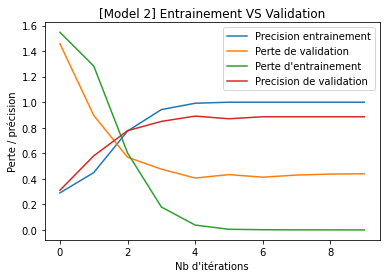

Erreur de test : 0.14

Précision moyenne sur set de validation : 0.782

Précision sur set de validation à la fin de l'entrainement : 0.886


In [21]:
from tensorflow.keras.layers import Embedding, Dense, Input, Flatten
from tensorflow.keras.layers import Conv1D, LSTM, GRU
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D 
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from matplotlib import pyplot

MAX_SEQ_LENGTH = 1000
EMB_DIM = 50
CLASSES = len(topics)

sequence_input = Input(shape=(MAX_SEQ_LENGTH,), dtype='int32')
embedding_layer = Embedding(MAX_WORDS, EMB_DIM,
                            input_length=MAX_SEQ_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Flatten()(x)

predictions = Dense(5, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])


model2 = model.fit(x_train, y_train, validation_split=0.1,
          epochs=10, batch_size=32)

#Graphique pour la discussion des performances
pyplot.plot(model2.history["acc"])
pyplot.plot(model2.history["val_loss"])
pyplot.plot(model2.history["loss"])
pyplot.plot(model2.history["val_acc"])
pyplot.title("[Model 2] Entrainement VS Validation")
pyplot.ylabel("Perte / précision")
pyplot.xlabel("Nb d'itérations")
pyplot.legend(["Precision entrainement", "Perte de validation","Perte d'entrainement","Precision de validation"], 
              loc="best", prop={"size":10})
pyplot.show()

#Pour l'erreur de test ;
precision_test_m2 = model.evaluate(x_test, y_test, verbose = 0)
print("Erreur de test :", round ((1 - precision_test_m2[1]) , 3))

#Infos additionnelles; précision moyenne et en fin d'entraînement sur le set de validation.
accuracy_m2 = model2.history['val_acc']
print()
print("Précision moyenne sur set de validation :", round ((sum(accuracy_m2)) / (len(accuracy_m2)) , 3))
print()
print("Précision sur set de validation à la fin de l'entrainement :", round ((accuracy_m2[len(accuracy_m2)-1]) , 3))

###  Modèle 3, couches neuronales 128 et 64 + LSTM 64 

Epoch 1/10
55/55 [==============================] - 5s 98ms/step - loss: 1.5008 - acc: 0.2783 - val_loss: 1.2615 - val_acc: 0.3575
Epoch 2/10
55/55 [==============================] - 5s 91ms/step - loss: 0.9190 - acc: 0.5548 - val_loss: 0.7210 - val_acc: 0.6736
Epoch 3/10
55/55 [==============================] - 5s 84ms/step - loss: 0.4192 - acc: 0.8482 - val_loss: 0.4386 - val_acc: 0.8394
Epoch 4/10
55/55 [==============================] - 5s 82ms/step - loss: 0.1241 - acc: 0.9654 - val_loss: 0.3807 - val_acc: 0.8860
Epoch 5/10
55/55 [==============================] - 5s 83ms/step - loss: 0.0454 - acc: 0.9890 - val_loss: 0.3862 - val_acc: 0.8705
Epoch 6/10
55/55 [==============================] - 5s 85ms/step - loss: 0.0322 - acc: 0.9942 - val_loss: 0.3428 - val_acc: 0.9119
Epoch 7/10
55/55 [==============================] - 5s 82ms/step - loss: 0.0148 - acc: 0.9965 - val_loss: 0.2490 - val_acc: 0.9378
Epoch 8/10
55/55 [==============================] - 5s 85ms/step - loss: 0.0123 - a

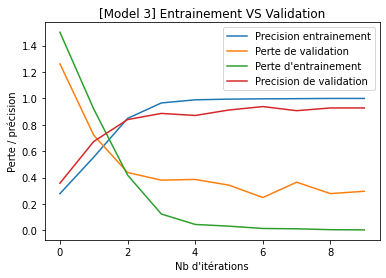

Erreur de test : 0.107

Précision moyenne sur set de validation : 0.824

Précision sur set de validation à la fin de l'entrainement : 0.927


In [23]:
from tensorflow.keras.layers import Embedding, Dense, Input, Flatten
from tensorflow.keras.layers import Conv1D, LSTM
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D 
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from matplotlib import pyplot

MAX_SEQ_LENGTH = 1000
EMB_DIM = 50
CLASSES = len(topics)

sequence_input = Input(shape=(MAX_SEQ_LENGTH,), dtype='int32')
embedding_layer = Embedding(MAX_WORDS, EMB_DIM,
                            input_length=MAX_SEQ_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

x2 = Conv1D(128, 5, activation='relu')(embedded_sequences)
x2 = MaxPooling1D(5)(x2)
x2 = Conv1D(64, 5, activation='relu')(x2)
x2 = MaxPooling1D(5)(x2)
x2 = LSTM(64)(x2)

predictions = Dense(5, activation='softmax')(x2)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

model3 = model.fit(x_train, y_train, validation_split=0.1,
          epochs=10, batch_size=32)

#Graphique pour la discussion des performances
pyplot.plot(model3.history["acc"])
pyplot.plot(model3.history["val_loss"])
pyplot.plot(model3.history["loss"])
pyplot.plot(model3.history["val_acc"])
pyplot.title("[Model 3] Entrainement VS Validation")
pyplot.ylabel("Perte / précision")
pyplot.xlabel("Nb d'itérations")
pyplot.legend(["Precision entrainement", "Perte de validation","Perte d'entrainement","Precision de validation"], 
              loc="best", prop={"size":10})
pyplot.show()

#Pour l'erreur de test ;
precision_test_m3 = model.evaluate(x_test, y_test, verbose = 0)
print("Erreur de test :", round ((1 - precision_test_m3[1]) , 3))

#Infos additionnelles; précision moyenne et en fin d'entraînement sur le set de validation.
accuracy_m3 = model3.history['val_acc']
print()
print("Précision moyenne sur set de validation :", round ((sum(accuracy_m3)) / (len(accuracy_m3)) , 3))
print()
print("Précision sur set de validation à la fin de l'entrainement :", round ((accuracy_m3[len(accuracy_m3)-1]) , 3))

###### L'ajout d'une couche neuronale long short term memory (LSTM) améliore considérablement la précision sur set de validation.

# Embeddings pré-entrainé
##### Le fichier glove100k est extrait du projet glove, entrainé sur le wikipédia anglais de 2014. 
##### Les 100 000 mots les plus rencontrés ont été extraits.

In [24]:
embeddings_index = {}
embeddings_vectors = []
with open('glove100K.100d.txt', 'rb') as test_file:
    mots_index = 0
    for line in test_file:
        values = line.decode('utf-8').split()
        mots = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[mots] = mots_index
        embeddings_vectors.append(vector)
        mots_index = mots_index + 1
index_v2 = {v: k for k, v in embeddings_index.items()}

In [25]:
glove_emb = np.vstack(embeddings_vectors)
glove_norms = np.linalg.norm(glove_emb, axis=-1, keepdims=True)
glove_emb_normed = glove_emb / glove_norms
print(glove_emb.shape)

(100000, 100)


In [26]:
def get_embeddings(mots):
    requete_index = embeddings_index.get(mots)
    if requete_index is None:
        return None
    else:
        return glove_emb[requete_index]

get_embeddings("sports")

array([ 2.5178e-01,  2.1679e-01, -1.8549e-01, -6.0748e-01, -5.3740e-01,
        2.5401e-01,  1.0652e-01,  4.9135e-01, -3.7166e-01, -1.1475e-01,
        1.9513e-01, -9.1305e-01,  2.5738e-01, -4.4816e-01, -6.3582e-01,
       -1.8812e-02,  1.1080e+00,  2.7677e-01, -5.9433e-01,  5.4188e-01,
       -6.0335e-01,  6.7308e-01, -2.1596e-01, -2.1152e-01,  5.7122e-01,
       -2.9668e-01,  4.6843e-01, -1.5950e-01, -2.1334e-01,  8.2496e-01,
       -3.7487e-01,  7.3475e-01, -8.0437e-01, -3.2657e-01,  8.2836e-02,
        5.2984e-01, -7.5724e-01,  7.8316e-01, -1.3998e+00,  3.3213e-01,
        2.4304e-01, -6.2245e-03, -4.1604e-01, -7.2283e-01, -4.1856e-01,
        2.4382e-01,  1.5314e-01, -1.2335e-01,  2.4820e-01, -7.6346e-01,
       -2.7486e-01, -1.1389e-01, -1.3353e-01,  4.5740e-01,  5.0033e-01,
       -1.9982e+00, -3.9918e-01,  1.2248e+00,  1.8659e+00,  6.6663e-01,
       -4.8694e-01,  4.8991e-01, -3.1767e-01, -4.4004e-01,  4.7801e-01,
       -7.6160e-02,  2.8952e-01, -1.1061e-01,  2.5534e-01,  9.05

In [27]:
def get_normed_embeddings(mots):
    requete_index = embeddings_index.get(mots)
    if requete_index is None:
        return None
    else:
        return glove_emb_normed[requete_index]
    
get_normed_embeddings("sports")

array([ 4.09330614e-02,  3.52445729e-02, -3.01559828e-02, -9.87608805e-02,
       -8.73676538e-02,  4.12956029e-02,  1.73174571e-02,  7.98810869e-02,
       -6.04225174e-02, -1.86554473e-02,  3.17232050e-02, -1.48438841e-01,
        4.18434814e-02, -7.28594810e-02, -1.03368245e-01, -3.05835553e-03,
        1.80132791e-01,  4.49958034e-02, -9.66230333e-02,  8.80959854e-02,
       -9.80894491e-02,  1.09425791e-01, -3.51096354e-02, -3.43878046e-02,
        9.28659216e-02, -4.82326671e-02,  7.61548728e-02, -2.59306673e-02,
       -3.46836895e-02,  1.34117633e-01, -6.09443821e-02,  1.19451761e-01,
       -1.30770221e-01, -5.30920252e-02,  1.34670390e-02,  8.61385837e-02,
       -1.23108074e-01,  1.27322003e-01, -2.27572069e-01,  5.39959408e-02,
        3.95121574e-02, -1.01194624e-03, -6.76375851e-02, -1.17513880e-01,
       -6.80472702e-02,  3.96389663e-02,  2.48966906e-02, -2.00535916e-02,
        4.03510444e-02, -1.24119289e-01, -4.46852855e-02, -1.85156334e-02,
       -2.17086021e-02,  

In [29]:
# Le produit scalaire des 2 vecteurs normés est calculé directement avec numpy.dot (np.dot)
# On stock les topn + 1 meilleurs résultats par ordre décroissant
# Le mot demandé est obligatoirement exclu avec un filtre if dans le return (d'où topn + 1), puisque voir
# 'sports', 0.9999999 renvoyé par la fonction n'a aucun intérêt.

def most_similar(word, topn = 10):
    score_cosinus = np.dot(glove_emb_normed, get_normed_embeddings(word))
    top_resultats = np.argsort(score_cosinus)[:: -1][:topn + 1]
    return [(index_v2[idx], score_cosinus[idx]) for idx in top_resultats if index_v2[idx] != word]

#par exemple on peut afficher les 10 mots les plus "liés" à sports avec la fonction ci-dessus
most_similar("sports")

[('sport', 0.82153803),
 ('soccer', 0.73094195),
 ('basketball', 0.71282184),
 ('baseball', 0.7066798),
 ('football', 0.7061924),
 ('sporting', 0.6651639),
 ('entertainment', 0.66452074),
 ('professional', 0.65598255),
 ('tv', 0.64079183),
 ('media', 0.6349373)]

##### Pour finir, on peut importer TSNE pour une construire une carte personnalisée, et faire
##### de la belle dataviz avec le nombre de mots que l'on souhaite.

In [30]:
from sklearn.manifold import TSNE

word_emb_map = TSNE(perplexity=25).fit_transform(glove_emb_normed[:2000])

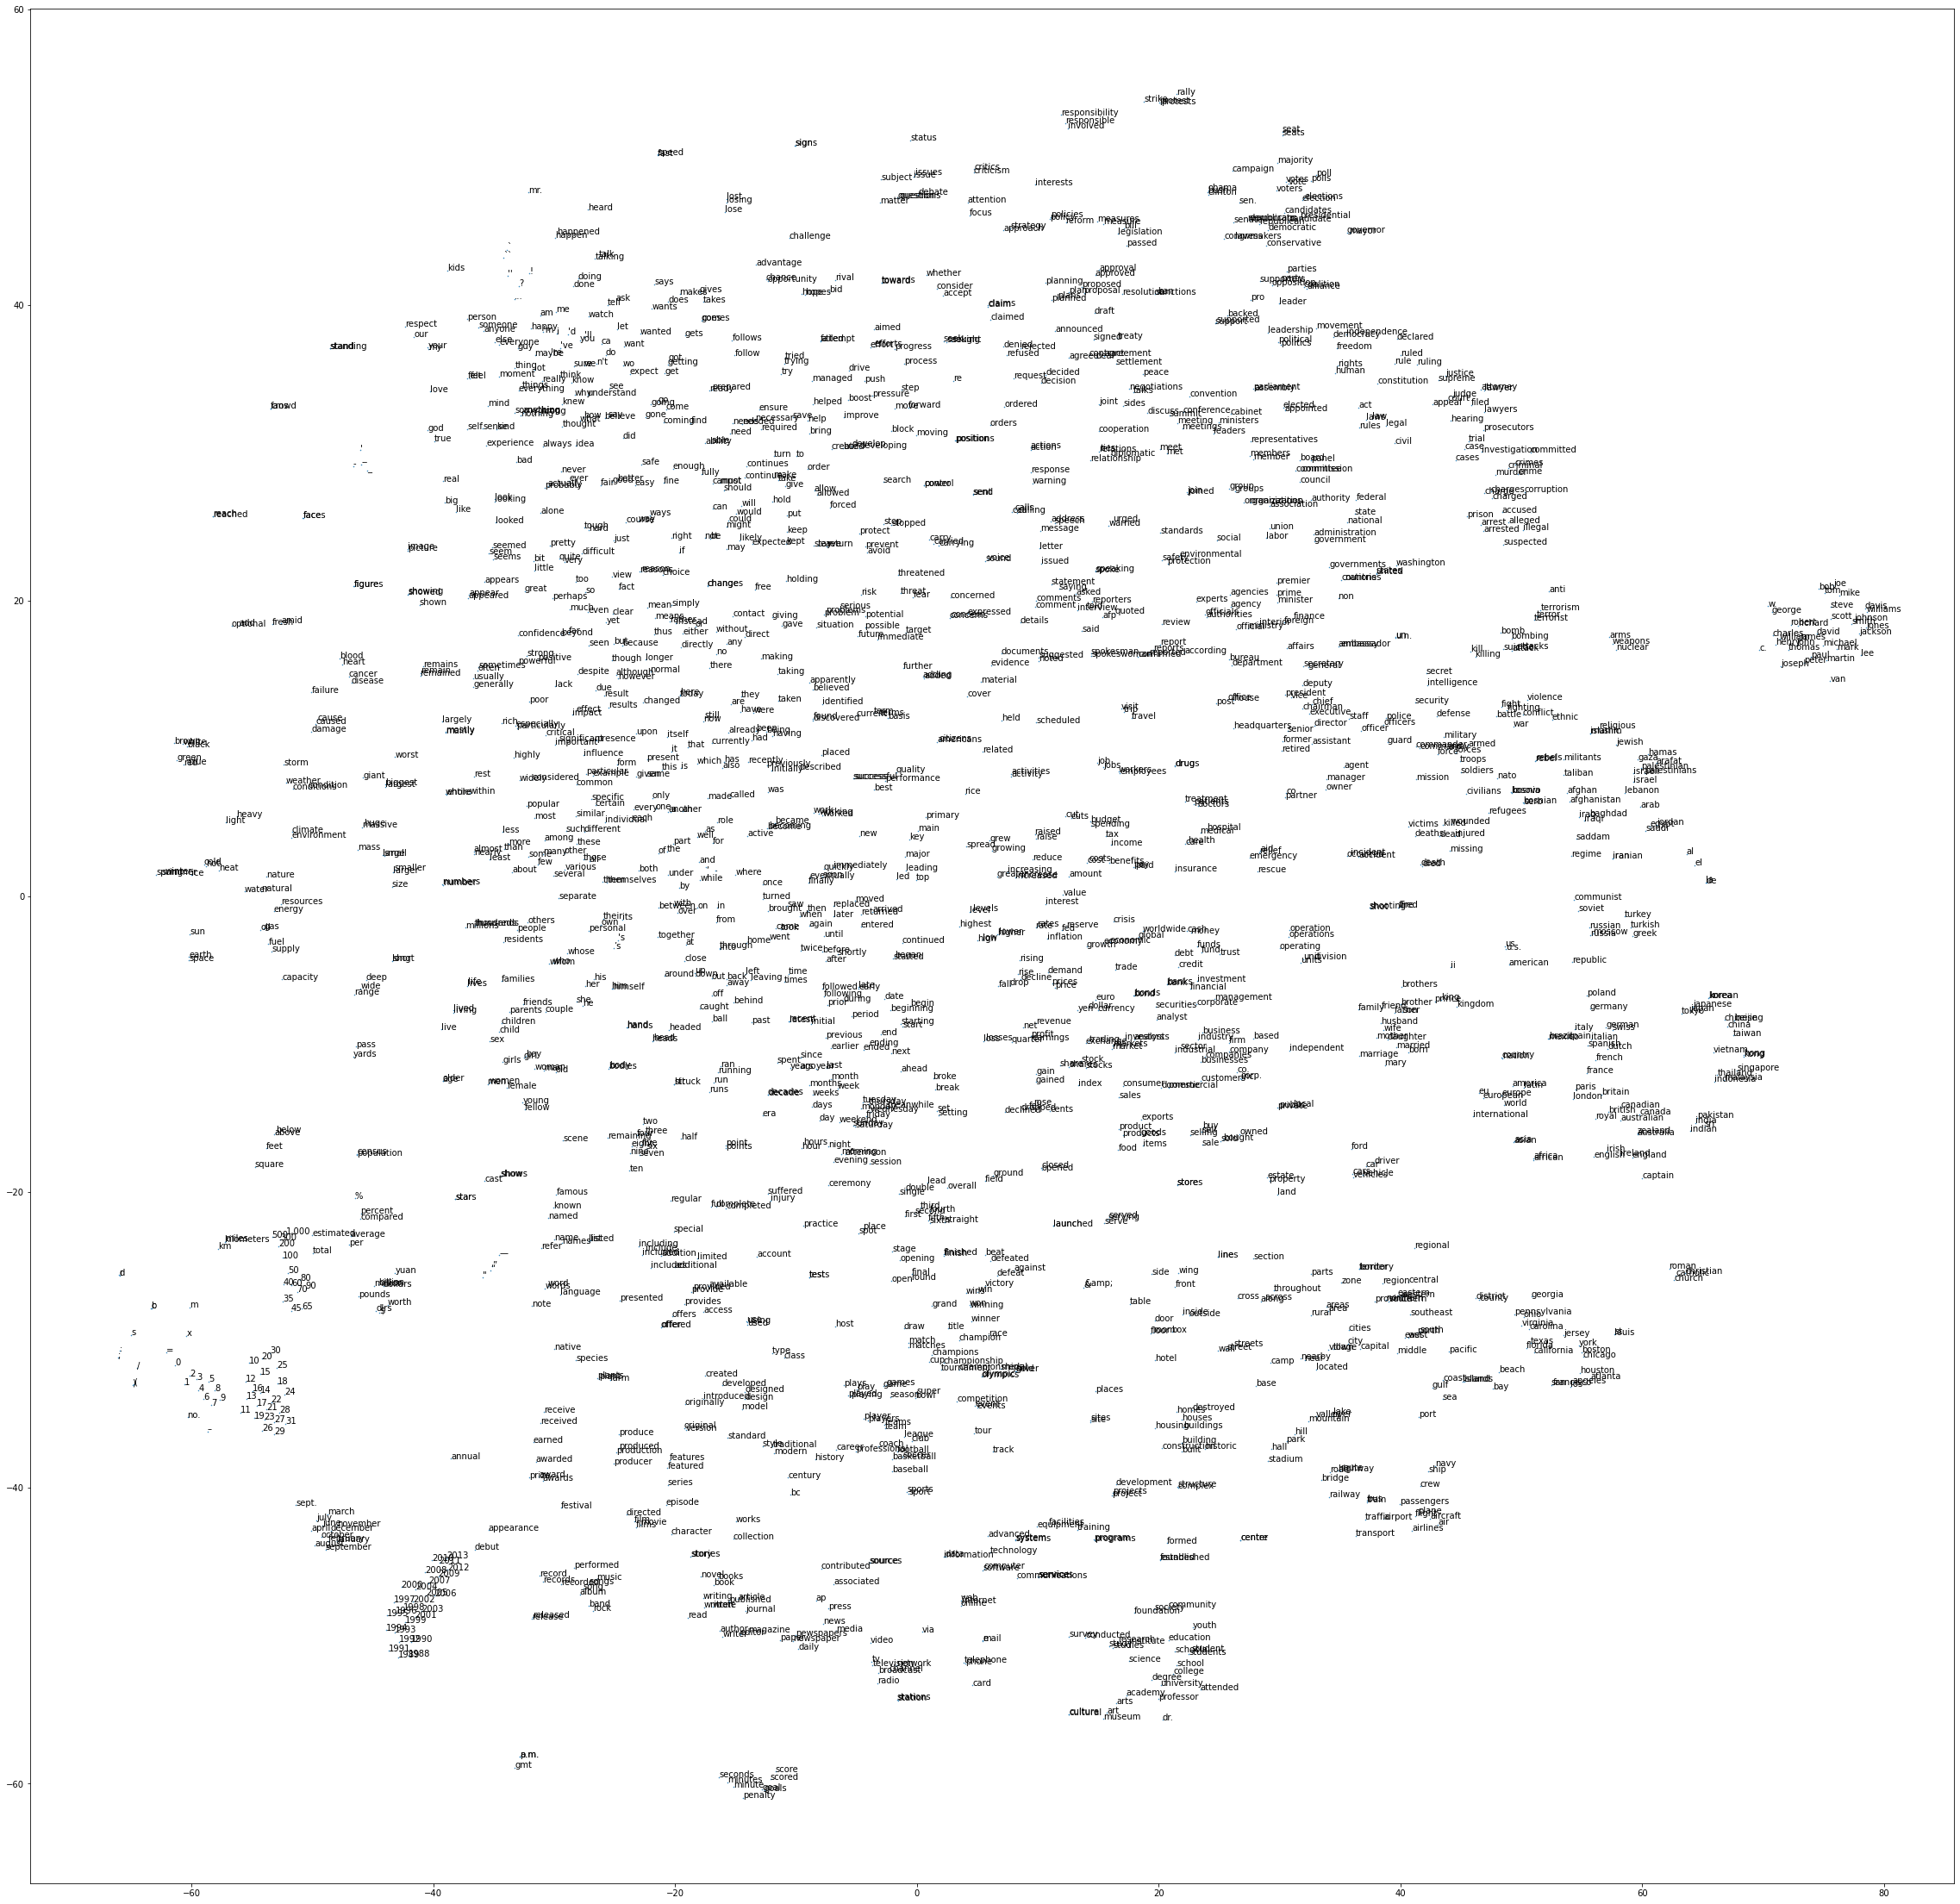

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 40))
axis = plt.gca()
plt.scatter(word_emb_map[:, 0], word_emb_map[:, 1], marker=".", s=1)

for idx in range(2000):
    plt.annotate(index_v2[idx],
                 xy=(word_emb_map[idx, 0], word_emb_map[idx, 1]),
                 xytext=(0, 0), textcoords='offset points')
plt.savefig("map_2000_mots.png")
plt.show()